In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("weather_data_extended.csv")

In [16]:
df['Observation Time'] = pd.to_datetime(df['Observation Time'])
df.set_index('Observation Time', inplace=True)

In [17]:
df_daily = df['Temperature (°C)'].resample('D').mean()
df_daily = df_daily.interpolate(method='linear')  

In [18]:
while len(df_daily) < 5:
    print("Not enough daily data. Extending dataset with last known value.")
    last_date = df_daily.index[-1]
    df_daily.loc[last_date + pd.Timedelta(days=1)] = df_daily.iloc[-1]


Not enough daily data. Extending dataset with last known value.
Not enough daily data. Extending dataset with last known value.
Not enough daily data. Extending dataset with last known value.


In [19]:
p_value_threshold = 0.05
if len(df_daily) > 5:
    def check_stationarity(series):
        result = adfuller(series.dropna())
        return result[1] < p_value_threshold  # Stationary if p-value < 0.05
    
    is_stationary = check_stationarity(df_daily)
    if not is_stationary:
        df_daily = df_daily.diff().dropna()


In [20]:
if df_daily.empty:
    raise ValueError("Data became empty after differencing. Try using more data or skipping differencing.")


In [21]:
if len(df_daily) < 30:
    print("Not enough data for seasonal modeling. Using ARIMA instead of SARIMA.")
    model = SARIMAX(df_daily, order=(1,1,0), enforce_stationarity=False)
else:
    model = SARIMAX(df_daily, order=(1,1,0), seasonal_order=(1,1,0,7), enforce_stationarity=False)

results = model.fit()


Not enough data for seasonal modeling. Using ARIMA instead of SARIMA.


In [22]:
forecast = results.forecast(steps=5)
forecast_dates = pd.date_range(df_daily.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')
forecast_series = pd.Series(forecast.values, index=forecast_dates)


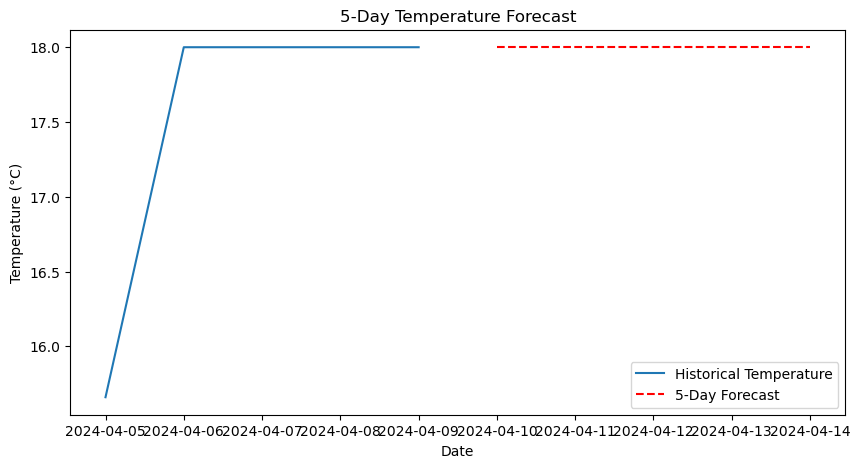

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(df_daily, label='Historical Temperature')
plt.plot(forecast_series, label='5-Day Forecast', linestyle='dashed', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('5-Day Temperature Forecast')
plt.legend()
plt.show()

In [24]:
print("Weather forecast for the next 5 days:")
print(forecast_series)

Weather forecast for the next 5 days:
2024-04-10    18.0
2024-04-11    18.0
2024-04-12    18.0
2024-04-13    18.0
2024-04-14    18.0
Freq: D, dtype: float64
